In [1]:
import os
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_context('paper', font_scale=1.2)
import pandas as pd
import scipy.stats
import warnings
from copy import copy

warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#Plotting function
from PlotDecodingResults import ModelPredictionPlots
from sklearn.model_selection import train_test_split
from sklearn.utils.random import sample_without_replacement
from RunBayesonNorewardData import PrepareBehaviorData as PreBeh
from RunBayesonNorewardData import PreprocessData as PreD
from RunBayesonNorewardData import RunNaiveBayes_ondata as rnb

rnb = rnb()
PreD = PreD()
m = ModelPredictionPlots()

Using TensorFlow backend.


Validation functions
Validation functions


## Prepare datasets

In [3]:
task_dict = {'Task1': '1 Fam Rew',
             'Task2': '2 No Rew',
             'Task3': '3 Fam Rew',
             'Task4': '4 Nov Rew'}

In [4]:
FolderName = '/home/sheffieldlab/Desktop/NoReward/ImagingData/Good_behavior/CFC4/'
animalname = os.path.basename(os.path.normpath(FolderName))
frame_lick_stop = 5154
task_numframes = {'Task1': 15000, 
                  'Task2': 20000, 
                  'Task3': 15000, 
                  'Task4': 15000}
#Track Parameters
tracklength = 200 #2m track
trackbins = 4 #5cm bins

In [5]:
SaveResults = os.path.join(FolderName, 'DecoderResults', 'BayesDecoder')
if not os.path.exists(SaveResults):
    os.mkdir(SaveResults)

In [6]:
from Placecells_and_LickCorrelation_EachAnimal import GetData as gd
A = gd(FolderName=FolderName, Task_NumFrames=task_numframes, TaskDict=task_dict, lick_stop=frame_lick_stop, v73_flag=1)

F (1924, 65000)
Fc (1924, 65000)
Fc3 (1924, 65000)
Number of PlaceCells in Task1 is 227
Number of PlaceCells in Task4 is 345
Number of PlaceCells in Task2 is 285
Number of PlaceCells in Task3 is 314


### Load required Data - load actual running data

#### Control Data

In [7]:
X = A.Fc3data_dict['Task1'].T
Y = A.Parsed_Behavior['running_data'].item()['Task1']

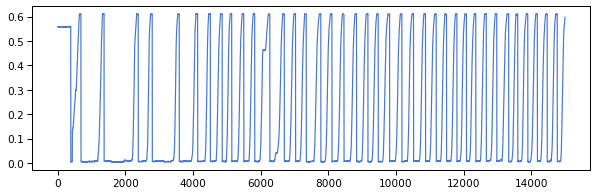

In [8]:
plt.figure(figsize = (10, 3))
plt.plot(Y)

#### No Reward Data

In [9]:
X_Norew = A.Fc3data_dict['Task2'].T
Y_Norew = A.Parsed_Behavior['running_data'].item()['Task2']

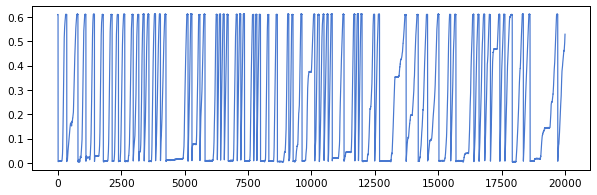

In [10]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew)

### Compare velocity of tasks and select laps with comparable speeds

Chosen speeds
Number of chosen laps : Task1 : 39, Task2 : 29
Remainin laps in 24
Task1 [6.71400904 4.0348612  3.90574564 3.45384119 3.45384119 3.58295675
 3.29244674 3.93802453 3.4215623  3.87346675 3.64751453 7.65009684
 7.10135571 3.93802453 3.97030342 4.6481601  4.3576501  4.09941898
 4.00258231 3.93802453 4.00258231 4.55132343 4.19625565 4.0348612
 3.67979342 4.22853454 3.64751453 3.74435119 3.80890897 3.97030342
 3.64751453 3.84118786 4.42220788 3.51839897 3.87346675 4.13169787
 4.26081343 3.84118786 3.67979342]
Task2 [4.19625565 5.32601679 5.06778567 4.3576501  3.45384119 4.51904454
 5.32601679 4.38992899 3.32472563 4.84183344 3.61523564 3.35700452
 4.58360232 6.03615236 3.55067786 3.93802453 3.64751453 5.35829567
 7.55326017 4.45448677 5.32601679 4.90639122 4.58360232 5.39057456
 5.51969012 4.71271788 6.90768238 7.39186572 6.71400904]
Worst lap speeds Task2
[ 8.55390575  9.84506133 10.68431246 17.23692705 13.39573919  7.87604906
 11.94318915 10.61975468 10.23240801 20.07746934]


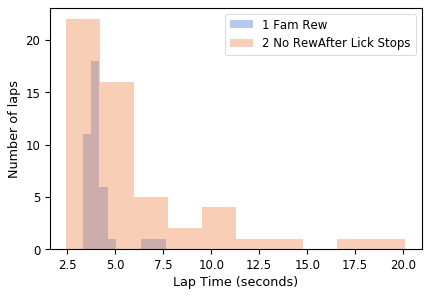

In [11]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
PreD.plot_velocity_distribution(A, [TaskA, TaskB])
lapvelocityA, lapvelocityB, common_v_lapsA, common_v_lapsB, worst_lapsB = PreD.get_laps_of_similar_velocity(A, TaskA='Task1', TaskB='Task2', tol=0, after_stoplick=1)

In [15]:
# These laps dont have correct imaging data
common_v_lapsA_corrected = np.array([i for i in common_v_lapsA if i not in [0, 1]])

Data shapes :  (7064, 1924) (7064, 1)
[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38]
[ 7 29 28 17  8  5 37 26 30 11 13 32 35  4 34 24  9 25 14  6 31 10 22 12
 15  2 20 21 23]
New data shapes :  (5036, 1924) (5036, 1)


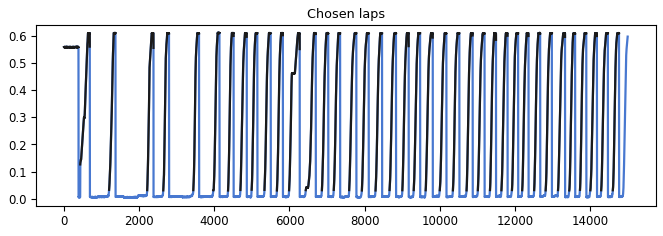

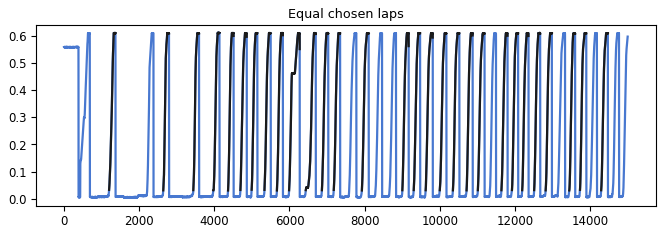

In [47]:
#Equalize laps between tasks
X_v_new, Y_v_new = PreD.compile_data_from_thresholdedlaps(A, Task=TaskA, X_data=X, Y_data=Y, thresholded_laps=common_v_lapsA, E_correction=1, figureflag=1)
X_v_eq, Y_v_eq = PreD.equalise_laps_with_numlaps_innorew(A, X, Y, Tasklabel='Task1', laps_current=common_v_lapsA_corrected, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1)

Data shapes :  (5761, 1924) (5761, 1)


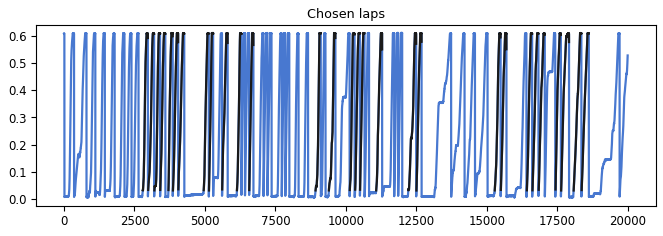

In [49]:
X_v_new_norew, Y_v_new_norew = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew, Y_data=Y_Norew, thresholded_laps=common_v_lapsB, E_correction=2, figureflag=1)

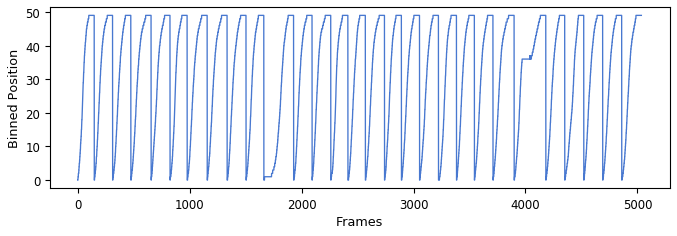

In [50]:
### prepare behavior datasets for classifying
B = PreBeh(BehaviorData=Y_v_eq, tracklength=tracklength, trackbins=trackbins)
y_v_eq_cat = B.position_binary

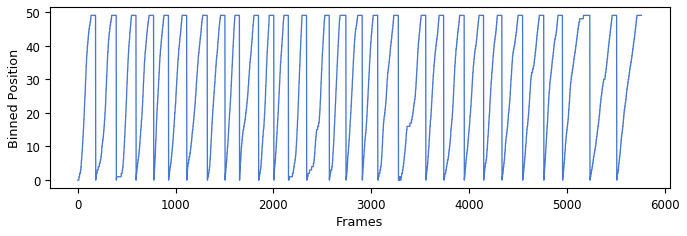

In [51]:
B = PreBeh(BehaviorData=Y_v_new_norew, tracklength=tracklength, trackbins=trackbins)
y_v_cat_norew = B.position_binary

### Run Naive Bayes on chosen lap data

#### Control data

Data shapes :  (4071, 1924) (1018, 1924) (4071,) (1018,)

Accuracy of test set:: 0.39%


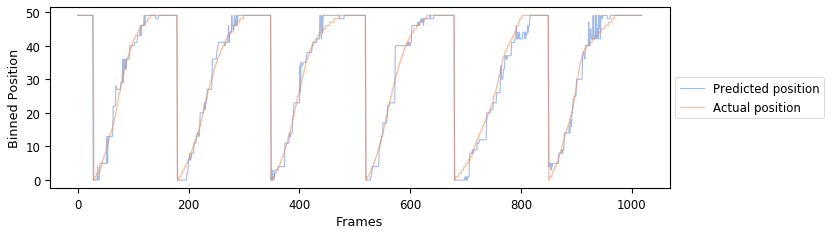

R2: 0.97
rho: 0.99




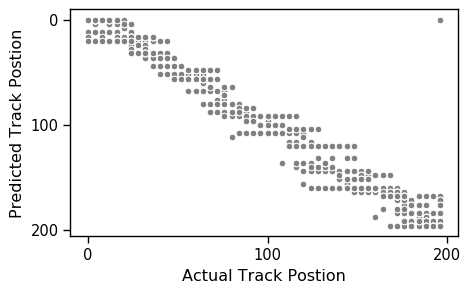

In [20]:
y_test, y_predicted = rnb.run_naivebayes(X_v_eq, y_v_eq_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)

#### No reward Data

Data shapes :  (4608, 1924) (1153, 1924) (4608,) (1153,)

Accuracy of test set:: 0.21%


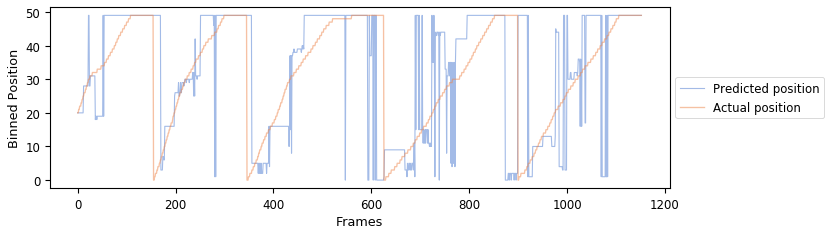

R2: -0.12
rho: 0.54




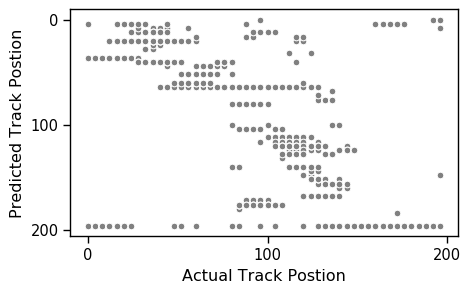

R2: -0.12
rho: 0.54




In [21]:
y_test, y_predicted = rnb.run_naivebayes(X_v_new_norew, y_v_cat_norew, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

### K-fold validation of tasks

In [22]:
nsplits = 5

#### Control Data

Performing 5-fold validation
Validation 1
(4071, 1924) (4071,) (1018, 1924) (1018,)

Accuracy of test set:: 0.38%


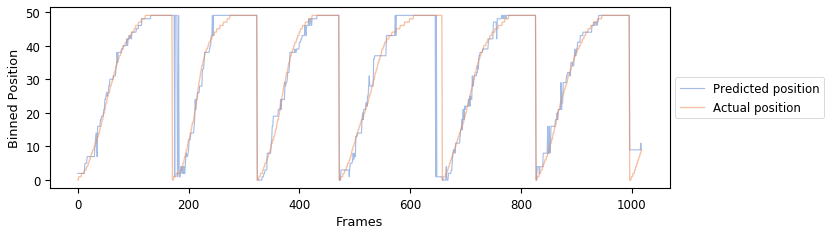

Validation 2
(4071, 1924) (4071,) (1018, 1924) (1018,)

Accuracy of test set:: 0.40%


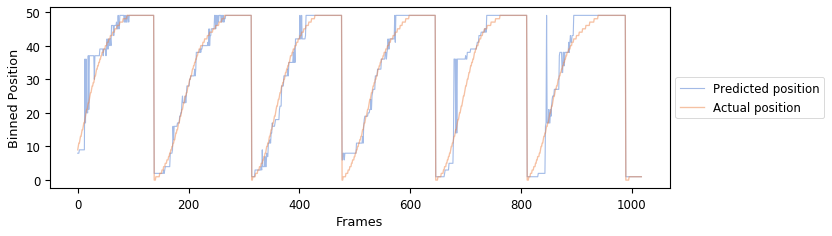

Validation 3
(4071, 1924) (4071,) (1018, 1924) (1018,)

Accuracy of test set:: 0.35%


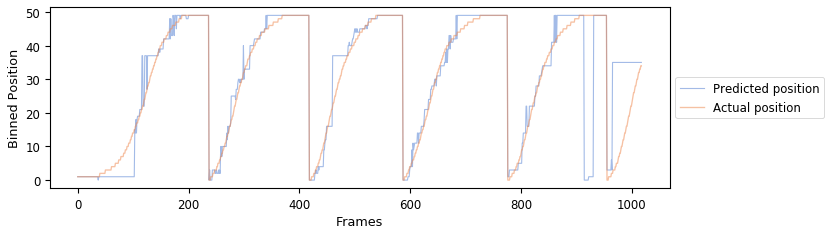

Validation 4
(4071, 1924) (4071,) (1018, 1924) (1018,)

Accuracy of test set:: 0.37%


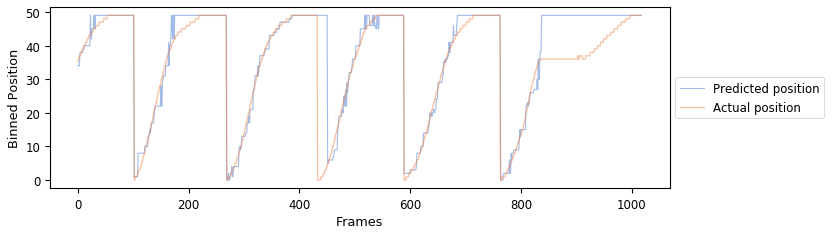

Validation 5
(4072, 1924) (4072,) (1017, 1924) (1017,)

Accuracy of test set:: 0.39%


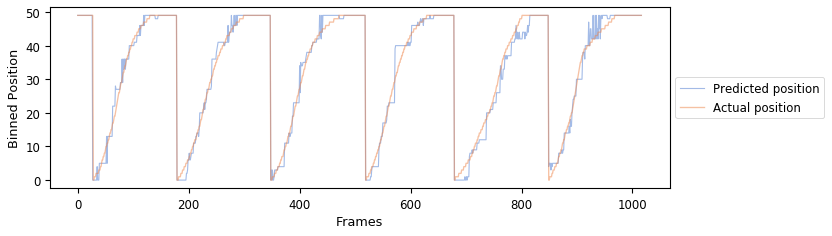

In [23]:
controlcv_dataframe = rnb.k_foldvalidation(X_data=X_v_eq, y_cat_data=y_v_eq_cat, split_size=nsplits, figureflag=1)

Performing 5-fold validation
Validation 1
(4608, 1924) (4608,) (1153, 1924) (1153,)

Accuracy of test set:: 0.29%


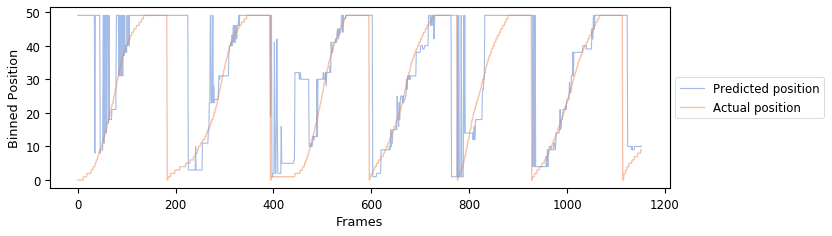

Validation 2
(4609, 1924) (4609,) (1152, 1924) (1152,)

Accuracy of test set:: 0.24%


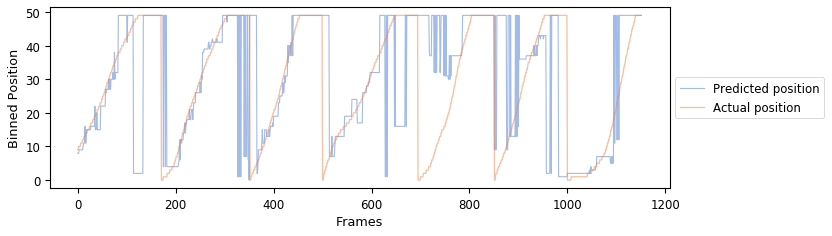

Validation 3
(4609, 1924) (4609,) (1152, 1924) (1152,)

Accuracy of test set:: 0.25%


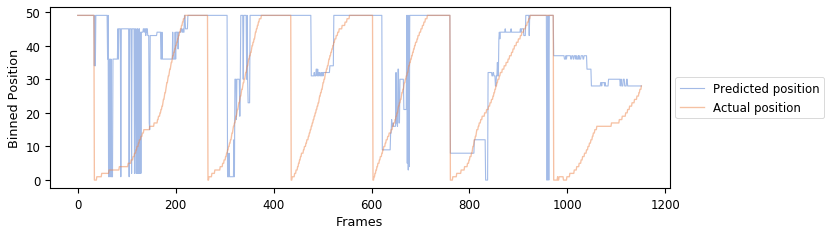

Validation 4
(4609, 1924) (4609,) (1152, 1924) (1152,)

Accuracy of test set:: 0.27%


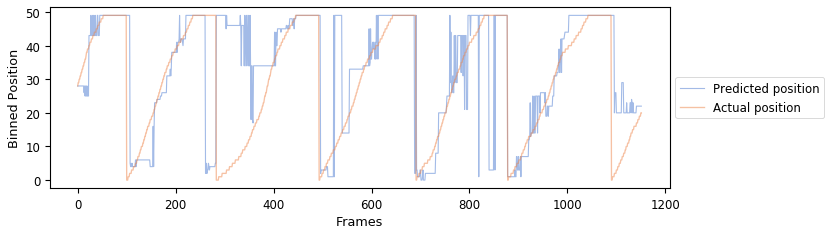

Validation 5
(4609, 1924) (4609,) (1152, 1924) (1152,)

Accuracy of test set:: 0.20%


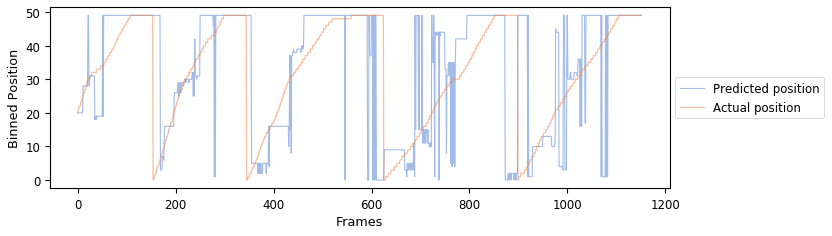

In [24]:
norewardcv_dataframe = rnb.k_foldvalidation(X_data=X_v_new_norew, y_cat_data=y_v_cat_norew, split_size=nsplits, figureflag=1)

### Compare Control with the worst but corrected laps

In [25]:
X_Norew_goodlaps = A.Fc3data_dict['Task2'][:, A.Parsed_Behavior['good_running_index'].item()['Task2']].T
Y_Norew_goodlaps = A.Parsed_Behavior['good_running_data'].item()['Task2']

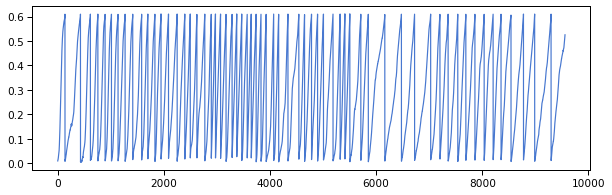

In [26]:
plt.figure(figsize = (10, 3))
plt.plot(Y_Norew_goodlaps)

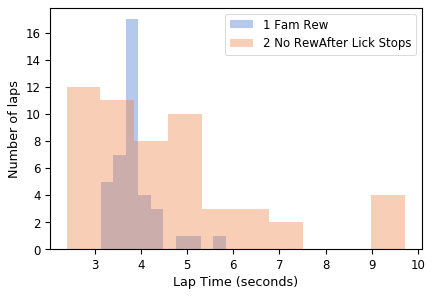

In [27]:
#Comparing two tasks
TaskA = 'Task1'
TaskB = 'Task2'
PreD.plot_corrected_velocity_distribution(A, [TaskA, TaskB])

In [28]:
correctedlaptime_worstlaps = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[worst_lapsB]

Data shapes :  (2149, 1924) (2149, 1)
[51 40 45 55 34 46 17 48 47 60]
[51 40 45 55 34 46 17 48 47 60]
New data shapes :  (2149, 1924) (2149, 1)


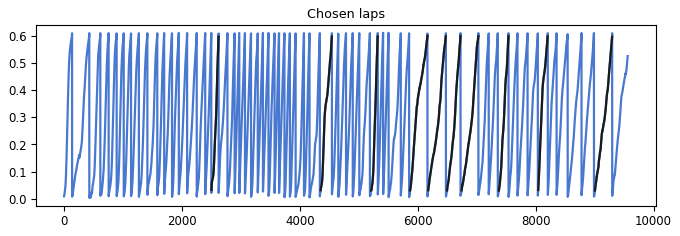

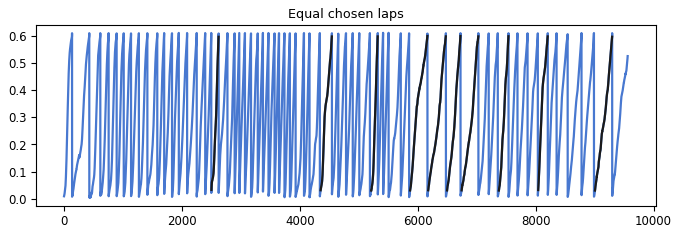

In [32]:
X_new_norew_goodlaps, Y_new_norew_goodlaps = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, 
                                              thresholded_laps=worst_lapsB, E_correction=1, 
                                              lapcorrectionflag=1, figureflag=1)
X_norew_goodlaps_eq, Y_norew_goodlaps_eq = PreD.equalise_laps_with_numlaps_innorew(A, X_Norew_goodlaps, Y_Norew_goodlaps, Tasklabel='Task2', laps_current=worst_lapsB, 
                                         numlaps_topick=np.size(common_v_lapsB), E_correction=1, lapcorrectionflag=1)

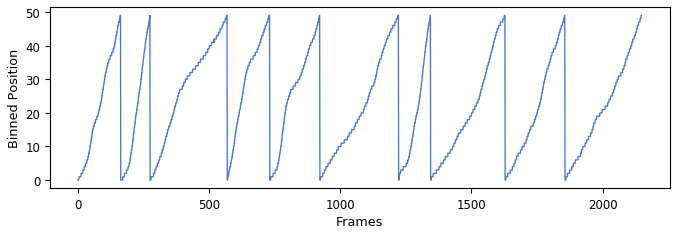

In [33]:
### prepare behavior datasets for classifying
B = PreBeh(BehaviorData=Y_norew_goodlaps_eq, tracklength=tracklength, trackbins=trackbins)
y_norew_goodlaps_eq_cat = B.position_binary

#### Run Bayes classifier on the corrected worst laps

Data shapes :  (1719, 1924) (430, 1924) (1719,) (430,)

Accuracy of test set:: 0.08%


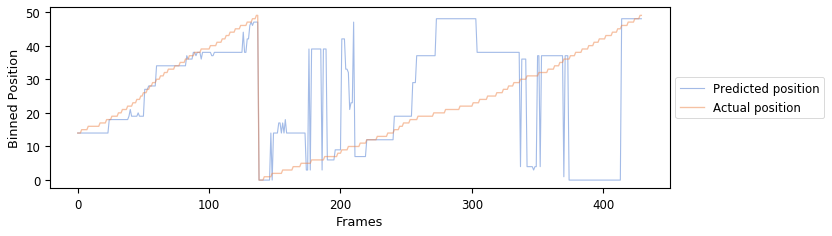

R2: -0.69
rho: 0.30




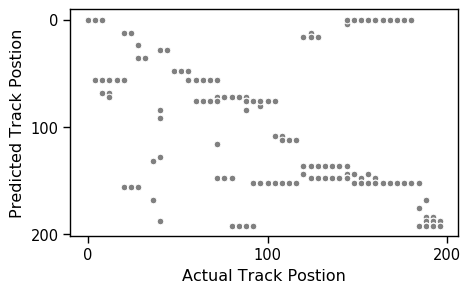

R2: -0.69
rho: 0.30




In [34]:
y_test, y_predicted = rnb.run_naivebayes(X_norew_goodlaps_eq, y_norew_goodlaps_eq_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

Performing 5-fold validation
Validation 1
(1719, 1924) (1719,) (430, 1924) (430,)

Accuracy of test set:: 0.06%


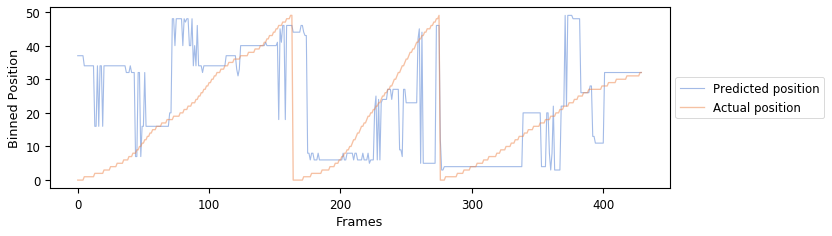

Validation 2
(1719, 1924) (1719,) (430, 1924) (430,)

Accuracy of test set:: 0.05%


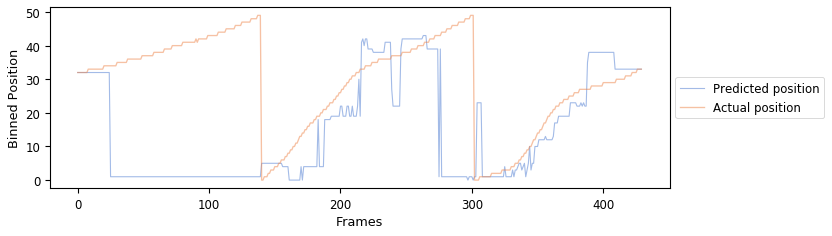

Validation 3
(1719, 1924) (1719,) (430, 1924) (430,)

Accuracy of test set:: 0.06%


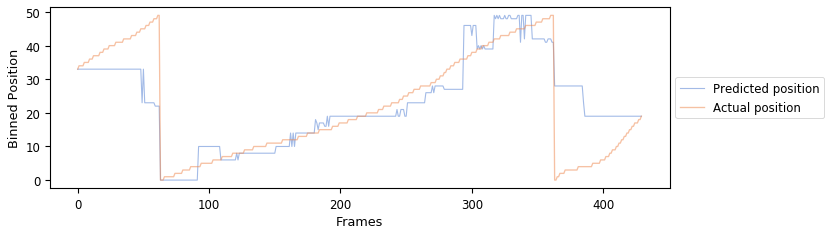

Validation 4
(1719, 1924) (1719,) (430, 1924) (430,)

Accuracy of test set:: 0.07%


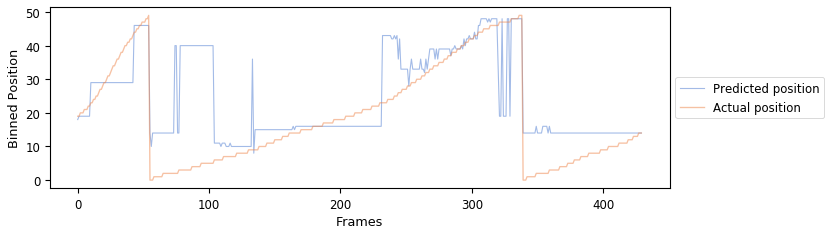

Validation 5
(1720, 1924) (1720,) (429, 1924) (429,)

Accuracy of test set:: 0.08%


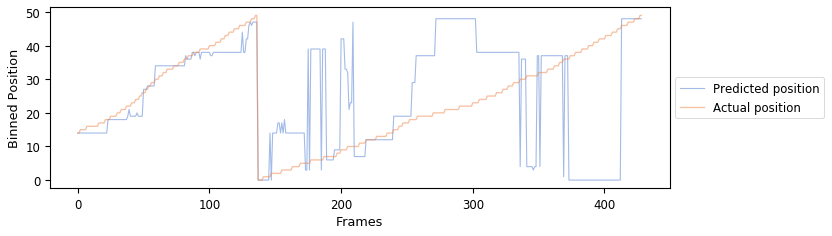

In [35]:
norewardcv_goodlaps_dataframe = rnb.k_foldvalidation(X_data=X_norew_goodlaps_eq, y_cat_data=y_norew_goodlaps_eq_cat, split_size=nsplits, figureflag=1)

In [36]:
R2_dataframe = pd.DataFrame(columns=['R2', 'TaskName', 'Animal'])
R2_dataframe['R2'] = pd.concat([controlcv_dataframe['R2'], norewardcv_dataframe['R2'], norewardcv_goodlaps_dataframe['R2']])
R2_dataframe['TaskName'].iloc[:nsplits] = 'Task1'
R2_dataframe['TaskName'].iloc[nsplits:nsplits*2] = 'Task2'
R2_dataframe['TaskName'].iloc[nsplits*2:nsplits*3] = 'Correctedlaps'
R2_dataframe['Animal'] = animalname

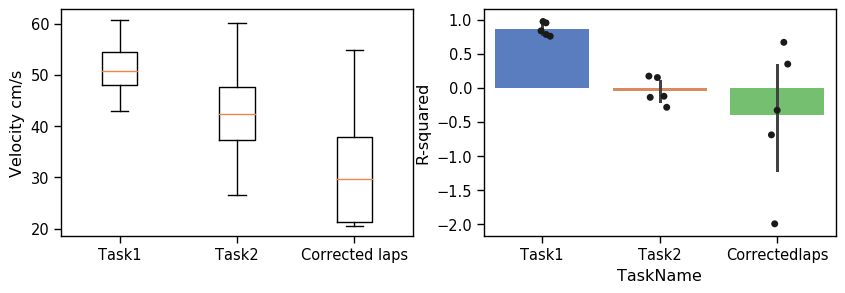

In [37]:
fs, ax1 = plt.subplots(1, 2, figsize=(10, 3), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps], showfliers=False)
ax1[0].set_xticklabels([TaskA, TaskB, 'Corrected laps'])
ax1[0].set_ylabel('Velocity cm/s')

# Plot modelling accuracy
sns.barplot(x='TaskName', y='R2', data=R2_dataframe, ax=ax1[1])
sns.stripplot(x='TaskName', y='R2', data=R2_dataframe, jitter=True, color='k',  ax=ax1[1])
ax1[1].set_ylabel('R-squared');

### Decoding while lick is present

In [38]:
stoplicklap = A.Parsed_Behavior['lick_stop'].item()
laptime_lick = np.asarray(A.Parsed_Behavior['goodlaps_laptime'].item()['Task2'])[:stoplicklap]

Data shapes :  (1094, 1924) (1094, 1)


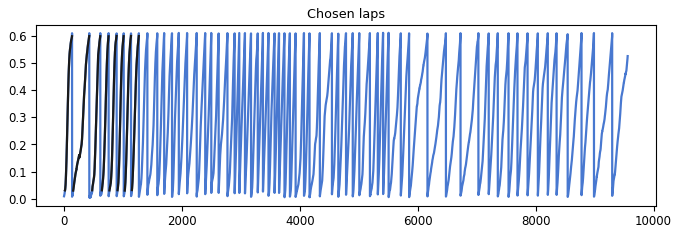

In [39]:
X_v_new_lick, Y_v_new_lick = PreD.compile_data_from_thresholdedlaps(A, Task=TaskB, X_data=X_Norew_goodlaps, Y_data=Y_Norew_goodlaps, thresholded_laps=np.arange(stoplicklap), E_correction=1, lapcorrectionflag=1, figureflag=1)

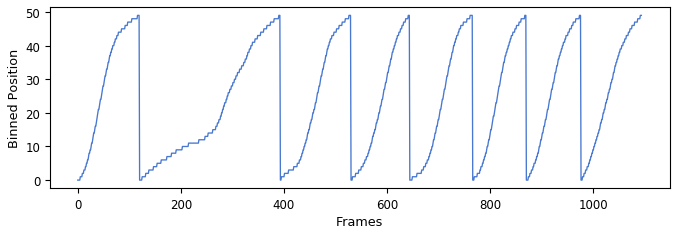

In [40]:
B = PreBeh(BehaviorData=Y_v_new_lick, tracklength=tracklength, trackbins=trackbins)
y_v_new_lick_cat = B.position_binary

Data shapes :  (875, 1924) (219, 1924) (875,) (219,)

Accuracy of test set:: 0.18%


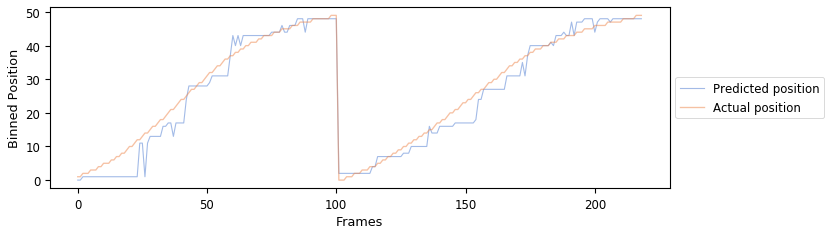

R2: 0.96
rho: 0.99




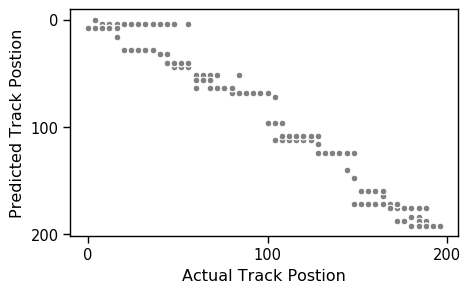

R2: 0.96
rho: 0.99




In [41]:
y_test, y_predicted = rnb.run_naivebayes(X_v_new_lick, y_v_new_lick_cat, testsize=0.2)
m.plot_accuracy_scatterplot(y_test, y_predicted, trackbins)
R2 = m.get_R2(y_test, y_predicted)
rho = m.get_rho(y_test, y_predicted)
print(f'R2: %.2f' % R2)
print(f'rho: %.2f\n\n' % rho)

Performing 5-fold validation
Validation 1
(875, 1924) (875,) (219, 1924) (219,)

Accuracy of test set:: 0.15%


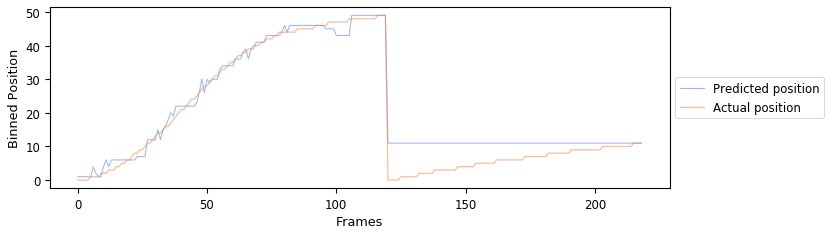

Validation 2
(875, 1924) (875,) (219, 1924) (219,)

Accuracy of test set:: 0.15%


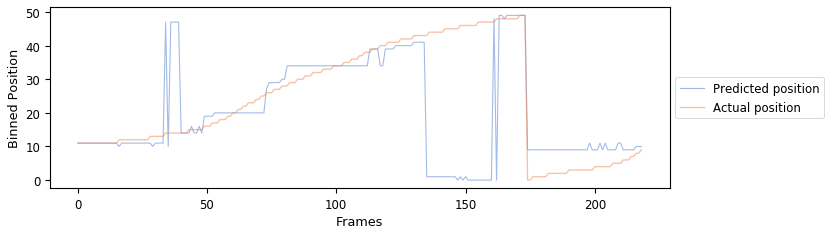

Validation 3
(875, 1924) (875,) (219, 1924) (219,)

Accuracy of test set:: 0.18%


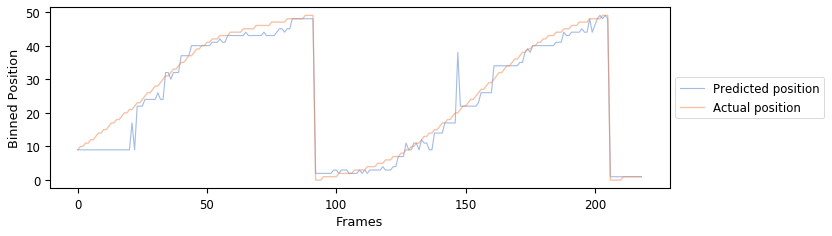

Validation 4
(875, 1924) (875,) (219, 1924) (219,)

Accuracy of test set:: 0.19%


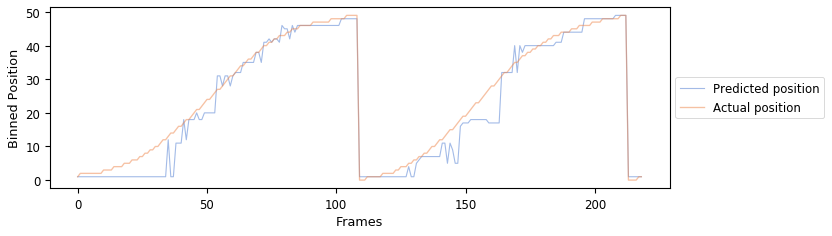

Validation 5
(876, 1924) (876,) (218, 1924) (218,)

Accuracy of test set:: 0.18%


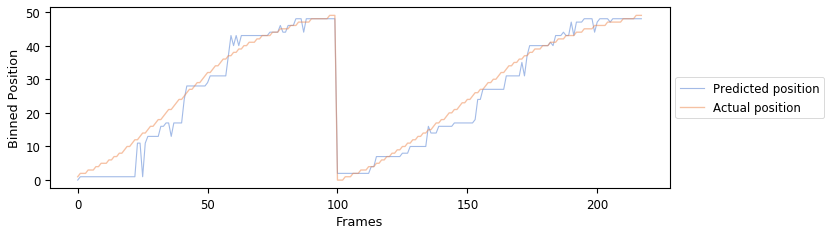

In [42]:
lickcv_dataframe = rnb.k_foldvalidation(X_data=X_v_new_lick, y_cat_data=y_v_new_lick_cat, split_size=nsplits, figureflag=1)

In [43]:
R2_dataframe = pd.DataFrame(columns=['R2', 'TaskName', 'Animal'])
R2_dataframe['R2'] = pd.concat([controlcv_dataframe['R2'], norewardcv_dataframe['R2'], norewardcv_goodlaps_dataframe['R2'], lickcv_dataframe['R2']])
R2_dataframe['TaskName'].iloc[:nsplits] = 'Task1'
R2_dataframe['TaskName'].iloc[nsplits:nsplits*2] = 'Task2'
R2_dataframe['TaskName'].iloc[nsplits*2:nsplits*3] = 'Correctedlaps'
R2_dataframe['TaskName'].iloc[nsplits*3:nsplits*4] = 'Task2_withlicks'
R2_dataframe['Animal'] = animalname

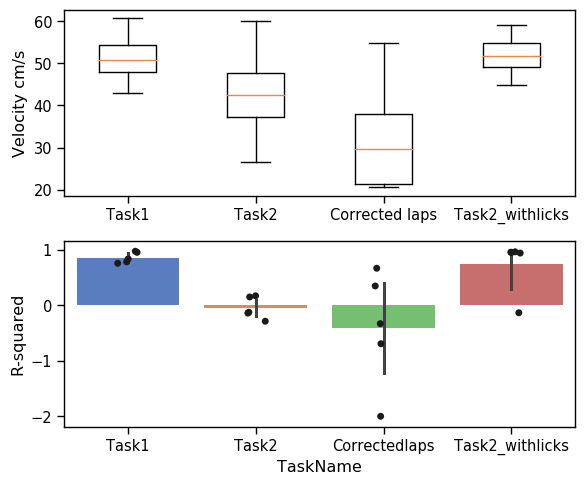

In [44]:
fs, ax1 = plt.subplots(2, 1, figsize=(6, 5), dpi=100)

# plot velocity distributions to show equality
ax1[0].boxplot([tracklength/lapvelocityA, tracklength/lapvelocityB,
                tracklength/correctedlaptime_worstlaps, tracklength/laptime_lick], showfliers=False)
ax1[0].set_xticklabels([TaskA, TaskB, 'Corrected laps', 'Task2_withlicks'])
ax1[0].set_ylabel('Velocity cm/s')

# Plot modelling accuracy
sns.barplot(x='TaskName', y='R2', data=R2_dataframe, ax=ax1[1])
sns.stripplot(x='TaskName', y='R2', data=R2_dataframe, jitter=True, color='k',  ax=ax1[1])
ax1[1].set_ylabel('R-squared');
fs.tight_layout()

### Save Results 

In [45]:
#Save R-squared dataframe
R2_dataframe.to_pickle(os.path.join(SaveResults, 'velocity_comparison_R2.pkl'))